
<ul>
<li>[Part 1: Load Data]
<li>[Part 2: Tokenizing and Stemming]
<li>[Part 3: TF-IDF]
<li>[Part 4: K-means clustering]
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation]
</ul>

# Load Data

In [2]:
import warnings
warnings.filterwarnings('ignore')
import re
import os

import numpy as np
import pandas as pd
import nltk
from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/yintonglu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yintonglu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [68]:
#import three lists: titles, synopses_wiki, synopses_imdb (The wiki and imdb synopses are seperated by "BREAKS HERE".)
titles = open('title_list.txt').read().split('\n')
titles = titles[:100] 
synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]
synopses = []     # Already ordered in popularity order
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
print('Example of 1 synopse', item)

Example of 1 synopse  Synopsis  [edit]  [  [  edit  edit  ]  ]  
  In the early days of World War II, Cohan comes out of retirement to star as President Roosevelt in the Rodgers and Hart musical I'd Rather Be Right. On the first night, he is summoned to meet the President at the White House, who presents him with a Congressional Gold Medal (in fact, this happened several years previously). Cohan is overcome and chats with Roosevelt, recalling his early days on the stage. The film flashes back to his supposed birth on July 4, whilst his father is performing on the vaudeville stage.  In the early days of   World War II  World War II  , Cohan comes out of retirement to star as President Roosevelt in the   Rodgers and Hart  Rodgers and Hart   musical   I'd Rather Be Right.  I'd Rather Be Right  I'd Rather Be Right  .   On the first night, he is summoned to meet the President at the   White House  White House  , who presents him with a   Congressional Gold Medal  Congressional Gold Medal   

# Data-Preprocessing: Tokenizing and Stemming

In [69]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
print (str(len(stopwords)) + " stop-words from nltk library are used..")
print ("Examples of stopwords: ",stopwords[:10])

179 stop-words from nltk library are used..
Examples of stopwords:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [70]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def tokenization_and_stemming(text):
    # exclude stop words and lowercase the rest
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token) #filter non-letter tokens
    
    stems = [stemmer.stem(t) for t in filtered_tokens] #stemming
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [71]:
# Example of a short sentence after tokenization and stemming
tokenization_and_stemming("In the lord your labor is never in vain. ")

['in', 'lord', 'labor', 'never', 'vain']

In [72]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)
#Compare tokenized_and_stemmed_results with tokenized_results for result interpretation
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print (vocab_frame_dict['happen'])
print (vocab_frame_dict['angel'])

happened
angeles


# TF-IDF



In [73]:
tfidf_model = TfidfVectorizer(max_df=0.9, max_features = 2000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,3))
tfidf_matrix = tfidf_model.fit_transform(synopses) 
tf_selected_words = tfidf_model.get_feature_names() 
print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")
print("In total there are ", len(tf_selected_words), "term-frequency selected words (features)")
print("Examples of them are: ", tf_selected_words[0:5],tf_selected_words[-5:-1])
print("Model Summary below")
tfidf_model.get_params()


In total, there are 100 synoposes and 1305 terms.
In total there are  1305 term-frequency selected words (features)
Examples of them are:  ["'d", "'m", "'s apart", "'s bodi", "'s death"] ['york citi', 'young', 'young man', 'young woman']
Model Summary below


{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.9,
 'max_features': 2000,
 'min_df': 0.1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming(text)>,
 'use_idf': True,
 'vocabulary': None}

# Document Similarity (Cosine similarity)

In [74]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print (cos_matrix)
print(cos_matrix.shape)

[[1.         0.07289099 0.08904917 ... 0.07365267 0.11985441 0.07697231]
 [0.07289099 1.         0.24039994 ... 0.07267906 0.11486799 0.05750792]
 [0.08904917 0.24039994 1.         ... 0.09032729 0.11719362 0.12189691]
 ...
 [0.07365267 0.07267906 0.09032729 ... 1.         0.15819013 0.09437982]
 [0.11985441 0.11486799 0.11719362 ... 0.15819013 1.         0.07113557]
 [0.07697231 0.05750792 0.12189691 ... 0.09437982 0.07113557 1.        ]]
(100, 100)


# Part 4: K-means clustering

In [93]:
from sklearn.cluster import KMeans
num_clusters  = 7
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
ranks = range(len(titles))
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])
frame.head(10)

,rank,title,cluster
3,0,The Godfather,3
1,1,The Shawshank Redemption,1
0,2,Schindler's List,0
1,3,Raging Bull,1
6,4,Casablanca,6
2,5,One Flew Over the Cuckoo's Nest,2
6,6,Gone with the Wind,6
1,7,Citizen Kane,1
0,8,The Wizard of Oz,0
2,9,Titanic,2


In [94]:
print ("Number of films included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
1,48
6,23
2,9
4,7
3,5
0,5
5,3


In [95]:
print(num_clusters)

7


In [96]:
print ("<Document clustering result by K-means>")
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print (vocab_frame_dict[tf_selected_words[ind]] + ",", end='')
    print ()
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print ("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ")
    print (", ".join(cluster_movies))
    print ()

<Document clustering result by K-means>
Cluster 0 words:tom,german,camping,family,guard,worker,
Cluster 0 titles (5 movies): 
Schindler's List, The Wizard of Oz, To Kill a Mockingbird, The Pianist, The Grapes of Wrath

Cluster 1 words:car,police,father,man,new,fight,
Cluster 1 titles (48 movies): 
The Shawshank Redemption, Raging Bull, Citizen Kane, Psycho, Vertigo, On the Waterfront, West Side Story, The Silence of the Lambs, Chinatown, 12 Angry Men, Amadeus, Gandhi, Unforgiven, Rocky, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, The Good, the Bad and the Ugly, The Apartment, High Noon, The Exorcist, The French Connection, City Lights, It Happened One Night, Mr. Smith Goes to Washington, Rain Man, Annie Hall, Out of Africa, Good Will Hunting, Terms of Endearment, Fargo, Giant, Shane, The Green Mile, Close Encounters of the Third Kind, Network, Nashville, The Graduate, American Graffiti, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Wutherin

## Plot K-means Result

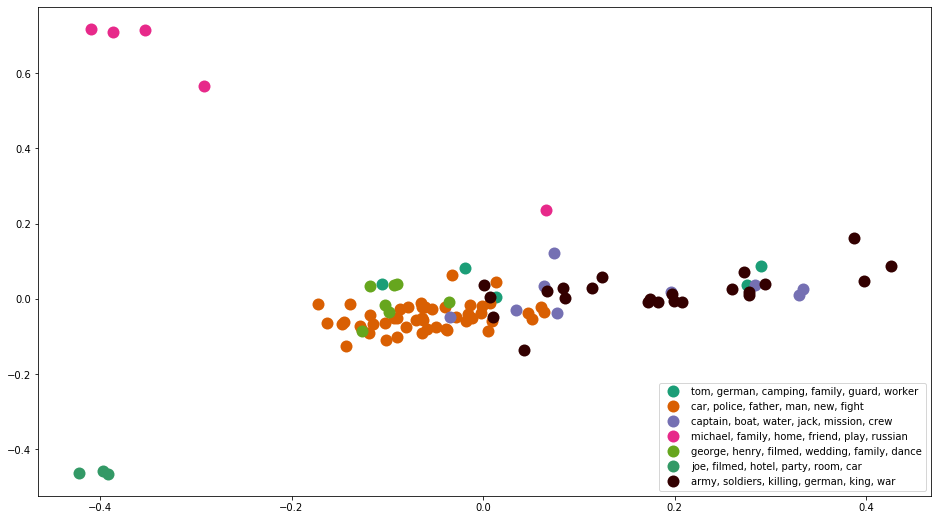

In [102]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)
xs, ys = X[:, 0], X[:, 1]

cluster_names, cluster_colors= {},{0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#339966', 6: '#330000'}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])
    
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)
plt.show() 

### In this section I use PCA to reduce dimensions to 2D for plotting and visibility. However, it looks like it is not a good trial.

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [105]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, learning_method = 'online')
tfidf_matrix_lda = (tfidf_matrix * 100) # turn them into integers
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)
lda.fit(tfidf_matrix_lda)# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)

(5, 1305)


In [106]:
n_top_words = 7
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [107]:
# documents and topics matrix
doc_topic = lda.transform(tfidf_matrix_lda)
print (doc_topic.shape)

(100, 5)


In [108]:
# print out the clusters and topics and titles of the movies
topic_doc_dict = {}
print ("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print ("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print ("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    print (', '.join(topic_doc_dict[i]))
    print ()

<Document clustering result by LDA>
Cluster 3 words: michael, family, german, british, war, camping
Cluster 3 titles (17 movies): 
The Godfather, Schindler's List, Raging Bull, Lawrence of Arabia, The Godfather: Part II, The Bridge on the River Kwai, Apocalypse Now, Doctor Zhivago, Patton, The Pianist, The Deer Hunter, The King's Speech, Tootsie, The Grapes of Wrath, Shane, Mutiny on the Bounty, Double Indemnity

Cluster 0 words: god, man, tom, sister, town, prison
Cluster 0 titles (15 movies): 
The Shawshank Redemption, Gone with the Wind, The Wizard of Oz, 12 Angry Men, Amadeus, Gandhi, Unforgiven, Rocky, The Philadelphia Story, To Kill a Mockingbird, Ben-Hur, High Noon, Annie Hall, The Maltese Falcon, A Clockwork Orange

Cluster 4 words: henry, singing, stage, performed, jeans, song
Cluster 4 titles (10 movies): 
Casablanca, Citizen Kane, Singin' in the Rain, A Streetcar Named Desire, An American in Paris, The Good, the Bad and the Ugly, Goodfellas, Mr. Smith Goes to Washington, Nas